# Video-Classification

Classification of videos into various actions.


Code by:

    Krishna Srikar Durbha - EE18BTECH11014
    V. L. Narasimha Reddy - EE18BTECH11046


## Imports

### Importing Libraries

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as pimg
import imageio
import cv2
import scipy
import os
import random

# Tensorflow Libraries
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import LSTM, GRU, Dense, Input, LSTM, GRU, Dropout, Reshape,Conv1D,MaxPooling1D, MaxPooling2D

### Connecting to Google Drive

In [ ]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive/My\ Drive/Video-Classification

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).
/gdrive/My Drive/Video-Classification


### Importing Dataset

In [ ]:
# Path for Videos and Features
Videos_Path = "Datasets/Videos"
Features_Path = "Datasets/Features"

# Interested no.of classes
N = 30

# Classes
Classes = os.listdir(Features_Path)
Classes.sort()
Classes = Classes[:N]
Classes2Index = dict(zip(Classes, np.arange(len(Classes))))
Index2Classes = dict(zip(np.arange(len(Classes)), Classes))

## Data Preparation and Processing

#### Importing Video Directories and Files

In [ ]:
def TrainValidData(Features_Path, Classes):
    X_TrainPath = []
    y_Train = []
    X_ValidPath = []
    y_Valid = []
    Indices = np.array([31, 84, 67, 88, 55, 82, 50, 17, 63, 59, 70, 46, 37, 86, 93,  2, 28,
       51, 69, 74, 30, 90, 61, 49, 41, 71, 94,  9, 27, 24, 40, 92, 21, 79,
       81, 95,  3, 87, 16, 62, 72,  6, 60,  5, 56, 19, 47, 45, 68, 29, 11,
       44, 58, 15, 43, 97, 76, 53, 96, 13, 12, 18,  4, 57, 48, 64, 39,  8,
       38, 25, 26, 66, 98,  7, 14, 36, 77,  0, 54, 73, 65, 22, 52, 99, 33,
       75, 80, 83, 10, 89, 34, 85, 91,  1, 78, 35, 32, 42, 20, 23])

    for c in Classes:
        # Enire Data
        Data = np.array([Features_Path+"/" + c + "/" + f for f in reversed(sorted(os.listdir(Features_Path + "/" + c)))])
        N = Data.shape[0]
        TrainIndices = Indices[:80]
        ValidIndices = Indices[80:]

        # Training Data
        X_TrainPath.append(Data[TrainIndices])
        y_Train.append(np.eye(len(Classes))[[Classes2Index[c]] * 80])

        # Validation Data
        X_ValidPath.append(Data[ValidIndices])
        y_Valid.append(np.eye(len(Classes))[[Classes2Index[c]] * 20])

    return np.array(X_TrainPath).flatten(), np.array(y_Train).reshape(-1, len(Classes)), np.array(X_ValidPath).flatten(), np.array(y_Valid).reshape(-1, len(Classes))

# Training and Validation Datasets
X_TrainPath, y_Train, X_ValidPath, y_Valid = TrainValidData(Features_Path, Classes)

### Dataset and DataLoaders

#### Dataset

In [ ]:
def Load_Data(X_Path, y, num_frames=20):
    Indices = np.arange(X_Path.shape[0])
    np.random.shuffle(Indices)
    
    for i in Indices:
        # Preprocess Video
        try:
            FeatureData = np.load(X_Path[i])
        except:
            FeatureData = np.load(X_Path[i].decode("utf-8"))

        N = FeatureData.shape[0]
        Ind = list(set(np.random.choice(np.arange(N), replace=False, size=num_frames)))
        features = FeatureData[Ind]

        # Label
        label = y[i]
        
        yield features, label

#### DataLoaders

In [ ]:
TrainGenerator = tf.data.Dataset.from_generator(Load_Data, args=[X_TrainPath, y_Train], output_signature=(
         tf.TensorSpec(shape=(20,2048), dtype=tf.float32),
         tf.TensorSpec(shape=(N,), dtype=tf.float32)))

ValidGenerator = tf.data.Dataset.from_generator(Load_Data, args=[X_ValidPath, y_Valid], output_signature=(
         tf.TensorSpec(shape=(20,2048), dtype=tf.float32),
         tf.TensorSpec(shape=(N,), dtype=tf.float32)))

## Designing Model

*   **Architecture:** CNN-RNN
*   **Feature-Extraction Model:** InceptionNetv3

Feature Extraction Model is used to extract features of each of the frames of the video.

In [ ]:
tf.keras.backend.clear_session()

Constructing a Model

In [ ]:
def Create_Model(Num_Frames=20, Num_Classes=N):
    # Input
    In = Input(shape=(Num_Frames,2048))

    # Temporal Feature Extraction
    x = GRU(units=2048, return_sequences=True)(In)
    x = GRU(units=512)(x)
    x = Dropout(0.5)(x)
    x = Dense(256, activation="relu")(x)
    x = Dense(128, activation="relu")(x)
    Out = Dense(Num_Classes, activation='softmax')(x)

    return tf.keras.Model(In,Out)

In [ ]:
Model = Create_Model()
Model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 20, 2048)]        0         
                                                                 
 gru (GRU)                   (None, 20, 2048)          25178112  
                                                                 
 gru_1 (GRU)                 (None, 512)               3935232   
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense (Dense)               (None, 256)               131328    
                                                                 
 dense_1 (Dense)             (None, 128)               32896     
                                                                 
 dense_2 (Dense)             (None, 30)                3870  

## Training the Model

Training Parameters

In [ ]:
Batch_Size = 256
Epochs = 10
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
Model.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=['accuracy'])

Data Generator

In [ ]:
TrainGenerator = (
    TrainGenerator
    .batch(Batch_Size)
)

ValidGenerator = (
    ValidGenerator
    .batch(Batch_Size)
)

Training Model

In [ ]:
History = Model.fit(TrainGenerator,
          validation_data=ValidGenerator,
          epochs=Epochs,
          verbose=1)

Epoch 1/10
10/10 [==============================] - 25s 2s/step - loss: 3.3348 - accuracy: 0.0908 - val_loss: 2.9673 - val_accuracy: 0.2850
Epoch 2/10
10/10 [==============================] - 18s 2s/step - loss: 2.8003 - accuracy: 0.2721 - val_loss: 2.4089 - val_accuracy: 0.4533
Epoch 3/10
10/10 [==============================] - 18s 2s/step - loss: 2.2135 - accuracy: 0.4596 - val_loss: 1.8824 - val_accuracy: 0.6133
Epoch 4/10
10/10 [==============================] - 18s 2s/step - loss: 1.6886 - accuracy: 0.6233 - val_loss: 1.4300 - val_accuracy: 0.7100
Epoch 5/10
10/10 [==============================] - 18s 2s/step - loss: 1.2697 - accuracy: 0.7404 - val_loss: 1.1322 - val_accuracy: 0.7417
Epoch 6/10
10/10 [==============================] - 18s 2s/step - loss: 0.9340 - accuracy: 0.8083 - val_loss: 0.9021 - val_accuracy: 0.8000
Epoch 7/10
10/10 [==============================] - 18s 2s/step - loss: 0.6782 - accuracy: 0.8700 - val_loss: 0.7160 - val_accuracy: 0.8200
Epoch 8/10
10/10 [==

Saving Model

In [ ]:
Model.save("Models/Video-Classification_Model.h5")

Plotting Loss

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


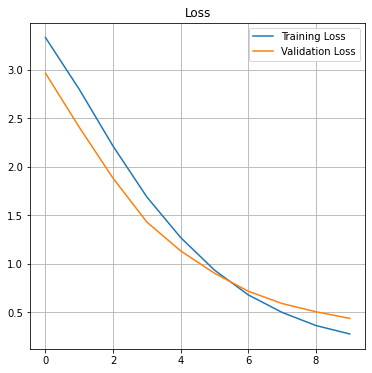

In [ ]:
plt.figure(figsize = (6,6))
plt.plot(np.arange(Epochs), History.history['loss'], label="Training Loss")
plt.plot(np.arange(Epochs), History.history['val_loss'], label="Validation Loss")
plt.title("Loss")
plt.grid()
plt.legend()
plt.savefig("Results/Loss.eps")
plt.show()

Plotting Accuracy

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


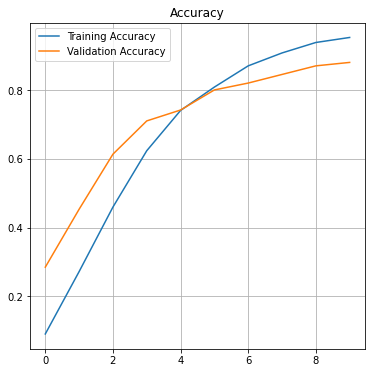

In [ ]:
plt.figure(figsize = (6,6))
plt.plot(np.arange(Epochs), History.history['accuracy'], label="Training Accuracy")
plt.plot(np.arange(Epochs), History.history['val_accuracy'], label="Validation Accuracy")
plt.title("Accuracy")
plt.grid()
plt.legend()
plt.savefig("Results/Accuracy.eps")
plt.show()